In [25]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.graphics.tsaplots as sgt

In [26]:
# 설치가 필요한 경우 주석을 제거하면 설치 가능함. 

import sys
#!{sys.executable} -m pip install arch
#!{sys.executable} -m pip install tqdm
from tqdm.notebook import tqdm

In [27]:
from datetime import datetime 

today = datetime.strftime(datetime.today(),"%Y-%m-%d")
import yfinance as yf
# Request historical data for past 5 years
df = yf.download("^GSPC", start='2021-01-01', end=today)
df.columns = [i.replace(" ", "_") for i in list(df)]
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj_Close,Volume
Date,,,,,,
2020-12-31,3733.270020,3760.199951,3726.879883,3756.070068,3756.070068,3172510000
2021-01-04,3764.610107,3769.989990,3662.709961,3700.649902,3700.649902,5006680000
2021-01-05,3698.020020,3737.830078,3695.070068,3726.860107,3726.860107,4582620000
2021-01-06,3712.199951,3783.040039,3705.340088,3748.139893,3748.139893,6049970000
2021-01-07,3764.709961,3811.550049,3764.709961,3803.790039,3803.790039,5080870000


# Train Test 분리

## 시간대를 기준으로 데이터를 나눠서 검증

* train : 2020-01-01 ~ 2021-07-31
* test : 2021-07-31~2021-09-29

* 주가 폭락 시점이 포함된 데이터를 train 데이터에 활용 

In [28]:
train_df = df.loc[:"2021-07-31"]
test_df = df.loc["2021-08-01":]

# 참고) 

* 2021년도 빅테크 규제에 대해서 금융당국에서 급제동을 건 영향으로 인해, 주가가 폭락하는 사태가 벌어지고 있다. 그래서 현 데이터로는 이러한 패턴을 찾기가 어렵다

# 데이터 변환 

* 이전에 EDA를 통해서 알 수 있듯이 현재 데이터는 정상성을 만족하지 못하고 있다. 
* 정상성을 만족시키기 위해서 앞에서 했던 기술들인 로그 변환, 차분, 로그 변환과 차분을 통해서 정상성을 만족하는 데이터를 만들고자 한다. 

In [29]:
def plot_acf_pacf(series, lags_n=10, stock_name=""):
    # plot_acf_pacf(df["Adjusted_Close"], lags_n= 180 , stock_name="")
    fig = plt.figure(figsize=(15,7))
    ax1 = fig.add_subplot(2, 1, 1)
    ax2 = fig.add_subplot(2, 1, 2)

    sgt.plot_acf(series, lags = lags_n, zero = False, ax=ax1)
    ax1.set_title(f"ACF {stock_name}")

    sgt.plot_pacf(series, lags = lags_n, zero = False, method = ('ols'), ax=ax2)
    ax2.set_title(f"PACF {stock_name}")

    plt.show()

def get_mean_var(df , window_size) :
    rolling_mean = df.rolling(window_size).mean()
    rolling_var = df.rolling(window_size).var()
    return rolling_mean , rolling_var

def plot_rolling(df:pd.Series , sep:str) :
    plt.figure(figsize=(18,12))
    plt.subplot(3, 1, 1)
    plt.plot(df)
    plt.title(f"[{sep}], Prices", size = 24)
    window_size = 6
    rolling_mean , rolling_var = get_mean_var(df,window_size)
    plt.subplot(3, 2, 3)
    plt.plot(rolling_mean)
    plt.title(f"Rolling Mean (Window = {window_size})", size = 24)
    plt.subplot(3, 2, 4)
    plt.plot(rolling_var)
    plt.title(f"Rolling Variance (Window = {window_size})", size = 24)
    window_size = 12
    rolling_mean , rolling_var = get_mean_var(df,window_size)
    plt.subplot(3, 2, 5)
    plt.plot(rolling_mean)
    plt.title(f"Rolling Mean (Window = {window_size})", size = 24)
    plt.subplot(3, 2, 6)
    plt.plot(rolling_var)
    plt.title(f"Rolling Variance (Window = {window_size})", size = 24)
    plt.tight_layout()
    plt.show()


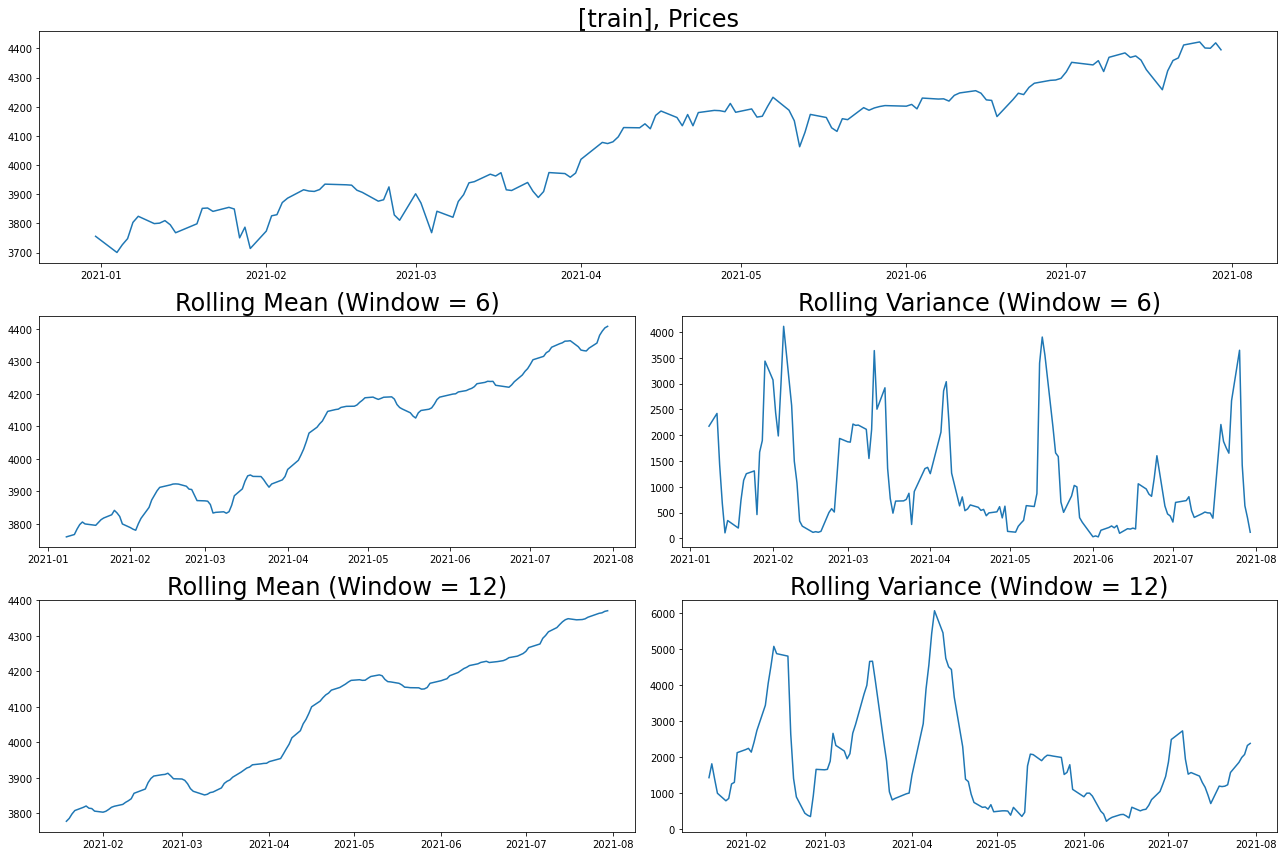

In [30]:
plot_rolling(train_df["Adj_Close"] , "train")

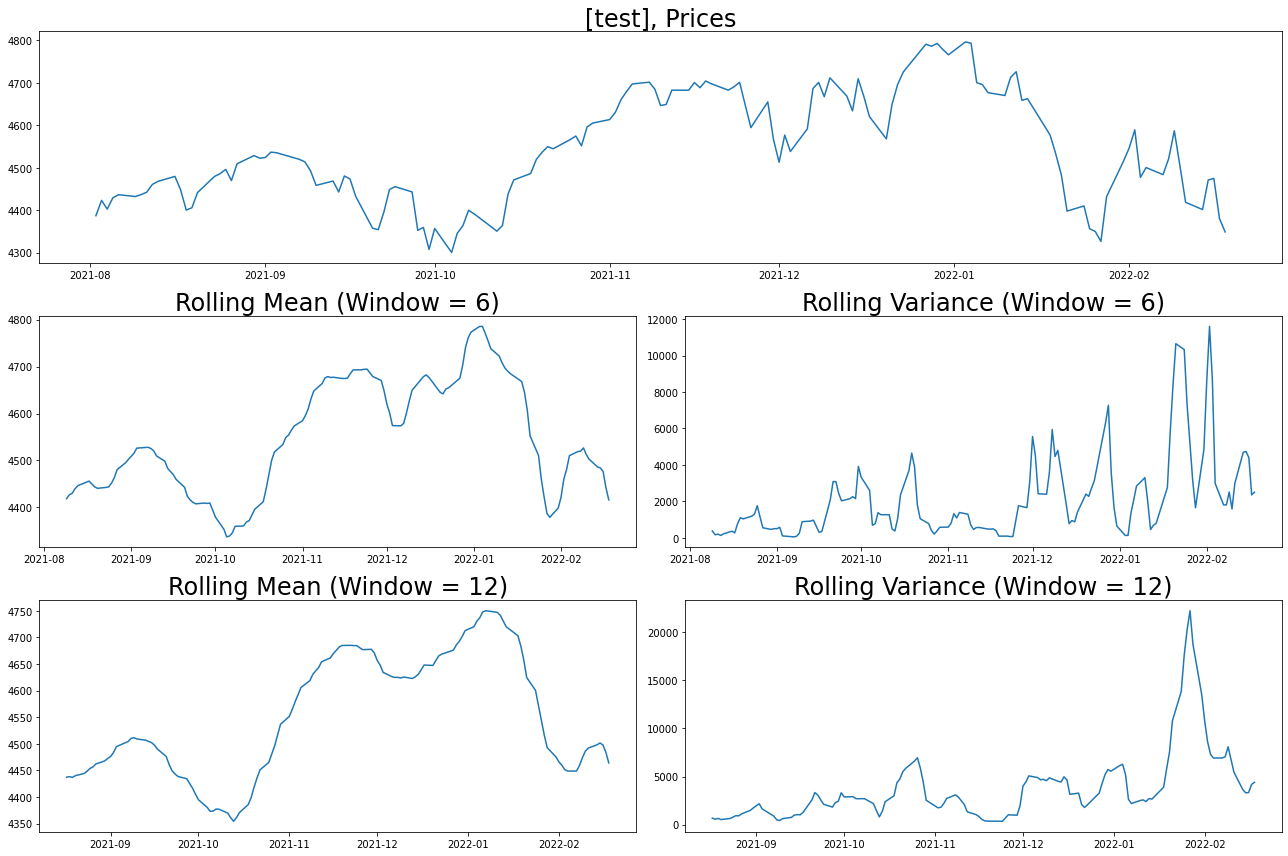

In [31]:
plot_rolling(test_df["Adj_Close"] , "test")

# Transformation 1. 로그 변환

$y_{\text{new}_t} = log(y_t)$

* $y_{\text{new}_t}$ : time t 에서 로그 변환 
* $y_t$ : time t에서의 기존 값

## 기존 데이터 정상성 검정

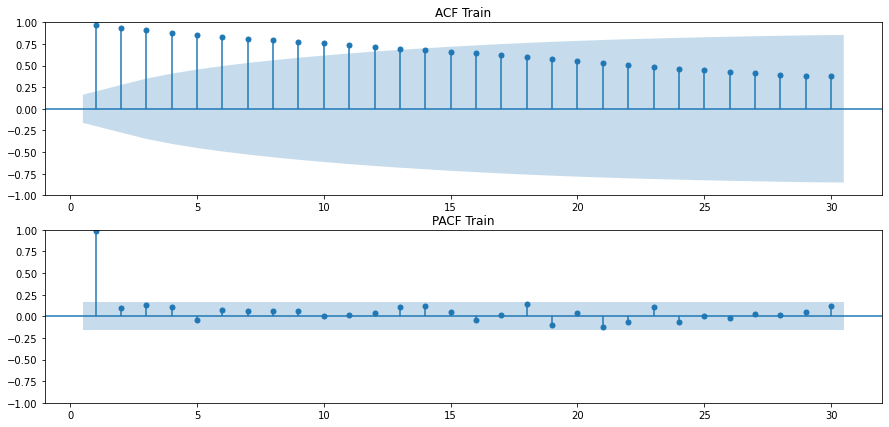

In [32]:
plot_acf_pacf(train_df["Adj_Close"],lags_n=30,stock_name = "Train")

In [33]:
from statsmodels.tsa.stattools import kpss , adfuller

def adf_test(df) :
    result = adfuller(df)
    print('Test statistic: ' , result[0])
    print('p-value: '  ,result[1])
    print("Critic values")
    for k,v in result[4].items() :
        print("\t%s : %.3f" % (k,v))


def kpss_test(df) :
    statistics , p_value , n_lags, critic_values = kpss(df)
    print(f"KPSS Statistics : {statistics}") 
    print(f"p-value : {p_value}") 
    print(f"num lags : {n_lags}")
    print("Critic Values : ")
    for k ,v in critic_values.items() :
        print(f"   {k} : {v}")

def stationary_test(df) :
    adf_test(df)
    kpss_test(df)

In [34]:
stationary_test(train_df["Adj_Close"])

Test statistic:  -0.9939763007978577
p-value:  0.7554549616867249
Critic values
	1% : -3.476
	5% : -2.882
	10% : -2.578
KPSS Statistics : 1.669133026788124
p-value : 0.01
num lags : 8
Critic Values : 
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


# Log Transformation 후 정상성 검정 

* 로그 변환을 해도, 정상성 검정에 대한 귀무가설을 기각할 만한 근거가 없으므로, 비정상성이라 할 수 있음.

In [35]:
stationary_test(np.log(train_df["Adj_Close"]).values)

Test statistic:  -1.073202932672436
p-value:  0.7256391269137347
Critic values
	1% : -3.476
	5% : -2.882
	10% : -2.578
KPSS Statistics : 1.667845622369281
p-value : 0.01
num lags : 8
Critic Values : 
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


# 차분 (difference)

$y_{\text{new}_t} = y_t - y_{t-1}$

* $y_{\text{new}_t}$ : time t 에서 로그 변환 
* $y_t$ : time t에서의 기존 값
* $y_{t-1}$ : time t-1 에서의 값

차분을 적용하고, 정상섬 검정을 하였을 때 검정이 정상성이라고 나왔지만, 시간에 의존하여 분산 값이 바뀌고 있음.

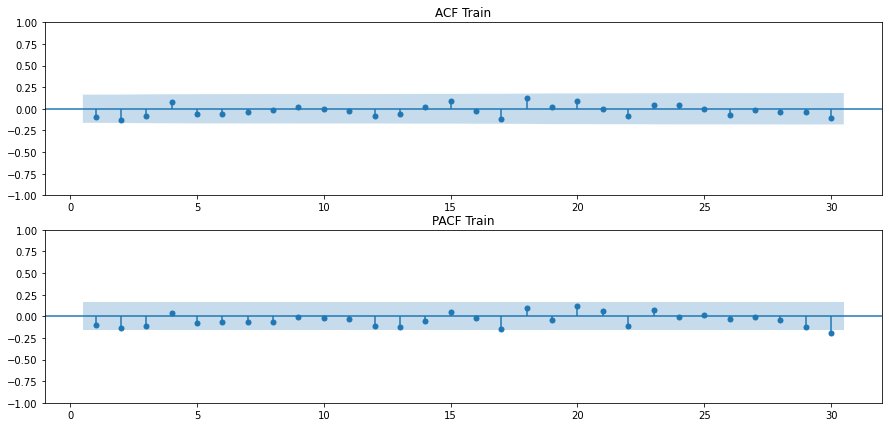

Test statistic:  -13.294797050051033
p-value:  7.241980751533061e-25
Critic values
	1% : -3.477
	5% : -2.882
	10% : -2.578
KPSS Statistics : 0.0452463064973337
p-value : 0.1
num lags : 12
Critic Values : 
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


In [36]:
plot_acf_pacf(train_df["Adj_Close"].diff(1).dropna(),lags_n=30,stock_name = "Train")
stationary_test(train_df["Adj_Close"].diff(1).dropna())

# 로그 변환 후 차분 

$y\_LT_t = \log(y_t)$<br>
$y\_LT_{t-1} = \log(y_{t-1})$

$y_{\text{new}_t} = y\_LT_t - y\_LT_{t-1}$<br>
$y_{\text{new}_t} = \log(y_t) - \log(y_{t-1})$

$y_{\text{new}_t} = \log(y_t / y_{t-1})$

* $y\_LT_t$: time t 에서 로그 변환
* $y\_LT_{t-1}$: time t-1에서 로그 변환
* $y_{\text{new}_t}$: time에서 로그 변환 후 차분된 값
* $y_t$: time t에서의 기존 값
* $y_{t-1}$: time t-1에서의 값


acf 와 pacf 그림을 보면, 기존에 변형 방식보다 더 정상성을 띄면서, 시간에 따른 분산도 안정적인 것을 알 수 있음
해당 데이터를 사용하여 ARMA에 적용해보고자 함

acf 그래프를 보면 시차 2 지점에서 가까워지고 있고, pacf 그래프롤 보면 시차 2 지점에서 가짜워지고 있음.  

그래서 **ARMA**에서 직관적으로 선택하게 되면 다음과 같이 선정하고자 함.

* p = 2 or 3 (PACF 그림을 보고 판단)
* d = 0 (정상성을 띄고 있이므로 0)
* q = 2 or 3 (ACF 그림을 보고 판단)

해당 데이터에 계절적인 부분에 대한 패턴도 충분히 고려할 가치가 있기 때문에 **SARMA** 도 적용도 가능해보임


----

* 참고) [ARIMA models for time series forecasting](https://people.duke.edu/~rnau/411arim.htm)
    * p is the number of autoregressive terms,
    * d is the number of nonseasonal differences needed for stationarity, and
    * q is the number of lagged forecast errors in the prediction equation.


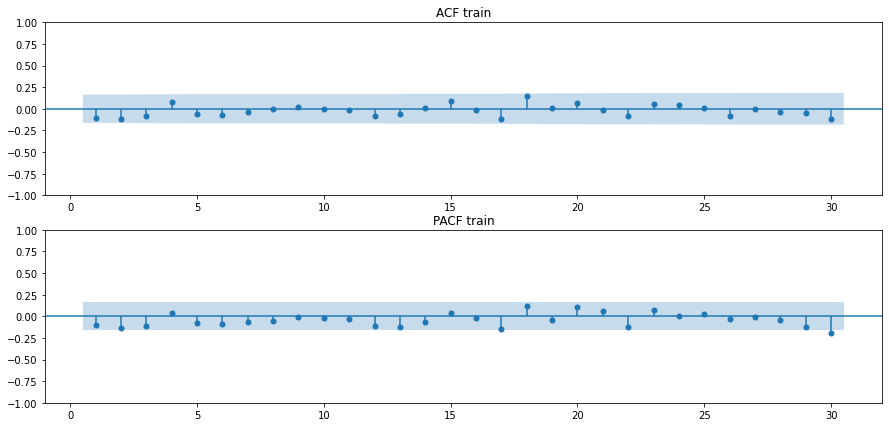

Test statistic:  -13.371095217088449
p-value:  5.196067971479385e-25
Critic values
	1% : -3.477
	5% : -2.882
	10% : -2.578
KPSS Statistics : 0.04578999908779542
p-value : 0.1
num lags : 12
Critic Values : 
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739


In [37]:
train_df["Adjusted_Close_log_diff"] = np.log(train_df["Adj_Close"].values)
train_df["Adjusted_Close_log_diff"] = train_df["Adjusted_Close_log_diff"].diff(1)

plot_acf_pacf(train_df["Adjusted_Close_log_diff"].dropna(),lags_n=30,stock_name="train")
stationary_test(train_df["Adjusted_Close_log_diff"].dropna())

# SARMA 적용 

In [38]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


# 파라미터 탐색 (Grid Search)

* SARIMAX 에서 결정을 해줘야 할 파라미터는 (p,d,q) x (P,D,Q) 를 설정해줘야 함.
* 특정 범위를 설정하고, 모든 조합을 생성해서 서치 하는 방법을 GRID SEARCH라고 함.
* S은 여러가지가 나올 수 있겠지만,  IR 자료의 주기인 분기마다 반복된다고 가정하여, 3으로 선정

In [39]:
import pickle
from pathlib import Path    
import sys
sys.path.append("./../")
from src.utils.utils import save_obj , load_obj


경우의 수 :  1458


In [ ]:

warnings.filterwarnings("ignore")

p = q = range(0,3)
d = range(0,3)        
season = [3,12] # 3,6,9,
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0],x[1],x[2],x[3]) for x in list(itertools.product(p,d,q,season))]
best_bic = np.inf 
best_pdq = None 
best_seasonal_pdq = None 
tmp_model = None
best_model = None 
train_data = train_df["Adj_Close"]
total_case = len(pdq) * len(seasonal_pdq)
print("경우의 수 : ", total_case)
case_dict = dict(pdq=[],season=[],bic =[],aic=[])

In [40]:
Path("./").joinpath("./../model/sarima_grid_search.pkl").is_file()

False

In [41]:
ck = Path("./").joinpath("./../model/sarima_grid_search.pkl")

if ck.is_file() :
    print(f"학습 파일 존재") 
    case_dict = load_obj("./../model/sarima_grid_search")
else :
    with tqdm(total=total_case, file=sys.stdout) as pbar:
        for param in pdq[0:5] :
            for param_seasonal in seasonal_pdq[0:5] :
                try :
                    tmp_mdl = SARIMAX(train_data , exog=None, order=param, seasonal_order=param_seasonal,enforce_stationarity=True ,enforce_invertibility=True)
                    res = tmp_mdl.fit(disp=False)
                    if res.bic < best_bic :
                        best_bic = res.bic
                        best_pdq = param
                        best_seasonal_pdq = param_seasonal
                        best_mdl = tmp_mdl  
                        pbar.set_description(f'best bic: {best_bic:.3f}')
                    case_dict["pdq"].append(param)
                    case_dict["season"].append(best_seasonal_pdq)
                    case_dict["bic"].append(res.bic)
                    case_dict["aic"].append(res.aic)
                    save_obj(case_dict , "sarima_grid_search")
                except Exception as e : 
                    print(e)
                    print(f"error case : pdq : {param} seasonal_pdq : {param_seasonal}")
                finally :
                    pbar.update(1)

  0%|          | 0/1458 [00:00<?, ?it/s]

# grid search 파라미터 결과물에서 최종 성능 추출하기

* bic 가 100미만인 모델 같은 경우, 잘못된 추정 결과들이 나와서 제거함.

In [42]:
case_pd = pd.DataFrame(case_dict).sort_values(by=["bic"])
case_pd = case_pd[case_pd["bic"] > 50]
print(case_pd.shape)
best_param = list(case_pd.iloc[[0],:].T.to_dict().values())[0]
print(best_param)

(25, 4)
{'pdq': (0, 1, 0), 'season': (0, 0, 0, 3), 'bic': 1436.2563591142434, 'aic': 1433.279625371823}


In [43]:
case_pd.head(10)

,pdq,season,bic,aic
16,"(0, 1, 0)","(0, 0, 0, 3)",1436.256359,1433.279625
15,"(0, 1, 0)","(0, 0, 0, 3)",1436.256359,1433.279625
21,"(0, 1, 1)","(0, 0, 0, 3)",1440.009430,1434.055962
20,"(0, 1, 1)","(0, 0, 0, 3)",1440.009430,1434.055962
17,"(0, 1, 0)","(0, 0, 0, 3)",1440.605039,1434.651571
18,"(0, 1, 0)","(0, 0, 0, 3)",1440.631193,1434.677726
22,"(0, 1, 1)","(0, 0, 0, 3)",1444.313786,1435.383585
23,"(0, 1, 1)","(0, 0, 0, 3)",1444.319697,1435.389496
19,"(0, 1, 0)","(0, 0, 0, 3)",1445.361027,1436.430826
24,"(0, 1, 1)","(0, 0, 0, 3)",1448.986296,1437.079361


In [44]:
print("best case ")
best_pdq = best_param["pdq"]
best_seasonal_pdq = best_param["season"]
best_bic = best_param["bic"]

print(best_pdq , best_seasonal_pdq , best_bic)

best case 
(0, 1, 0) (0, 0, 0, 3) 1436.2563591142434


# SARIMA 모델링 및 결과물 시각화하는 클래스 구성 

In [47]:
import sys
sys.path.append("./../")
from src.algorithms.sarima.sarima import SARIMA_MODEL

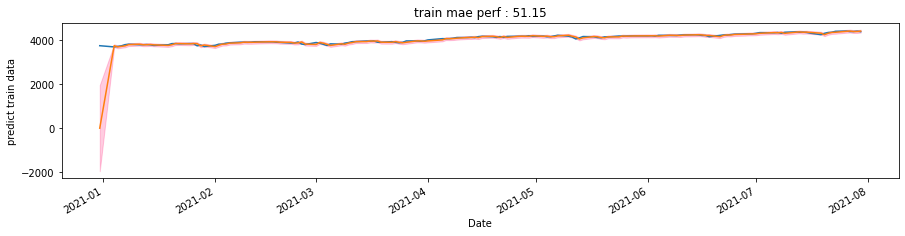

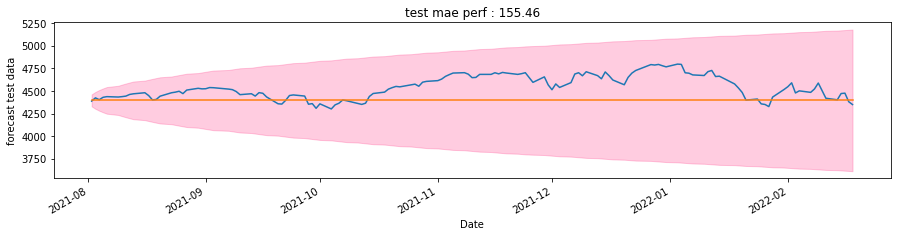

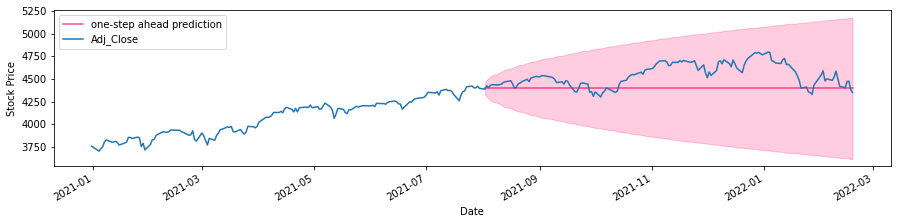

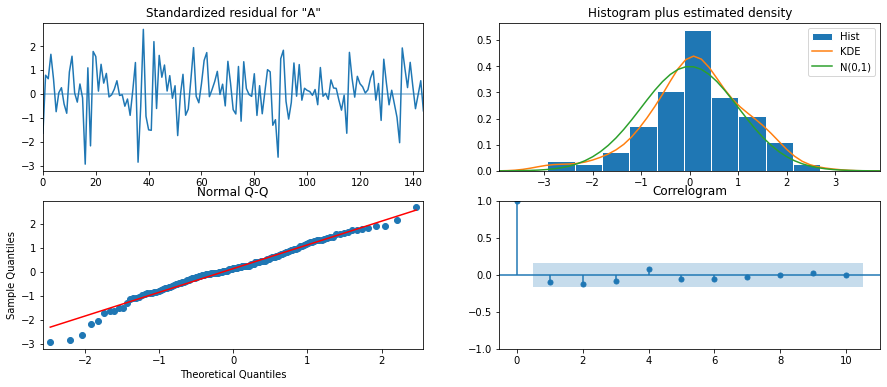

,mae,mse,msle,r2,mede,mape
train,51.149715,97756.245726,0.464152,-1.455194,20.714844,0.013161
test,155.463143,37215.334958,0.001809,-1.265437,126.280273,0.033592


In [48]:
train = train_df["Adj_Close"].dropna()
sarimax_kwargs = dict(exog=None, order=best_pdq, seasonal_order=best_seasonal_pdq,enforce_stationarity=True,enforce_invertibility=True)
sarima_model = SARIMA_MODEL(train , sarimax_kwargs)
sarima_model.plot_train_result()
sarima_model.plot_forecast(test_df["Adj_Close"].dropna())
sarima_model.plot_train_test(test_df["Adj_Close"].dropna())
sarima_model.summary()
sarima_model.plot_diagnstics(figsize=(15,6))
sarima_model.metrics(test=test_df["Adj_Close"].dropna())